# DESCRIPTION SYNOPSIS ANALYSIS

**Authors**
- Alejandro Urrego Lopéz
- Cesar Augusto Prieto Sarmiento

In this Jupyter workbook you will find the development of the analysis of the Anime descriptions, from the import of the necessary libraries to the preparation of the data and the methods used for the corresponding analysis. 

## Import necessary libraries

In [1]:
import pandas as pd   # For data manipulations
import numpy as np    # For maths
import igraph as ig   # For networks 
import openai        # AI implementations
from dotenv import load_dotenv
import nltk
import os
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')

In [2]:
# import necessary for NPL 

import nltk
nltk.download("punkt")
nltk.download("stopwords")  # Descargar el conjunto de datos de stopwords
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
english_sw = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from wordcloud import WordCloud  # For word cloud generation

# For plotting
import matplotlib.pyplot as plt
from plotnine import *
import matplotlib.colors as mcolors
import hashlib

import random # For setting random seed in plots

In [4]:
import os

data_folder_path = os.path.dirname(os.getcwd()) + os.sep + 'Data' + os.sep


In [5]:
data_folder_path

'C:\\Users\\Pc\\Desktop\\Anime-Network-Project\\Data\\'

In [6]:
english_sw = pd.read_csv(data_folder_path + 'stop_words_tidytext_R.csv', dtype={'id': str})
english_sw=set(english_sw['word'])

## Definition of important functions

In [7]:
# Adapted from ChatGPT
def adjustcolor(color_name, alpha):
    # Convert color name to RGB
    rgb = mcolors.CSS4_COLORS.get(color_name)
    if rgb is None:
        raise ValueError(f"The color '{color_name}' is not valid.")
    
    # Convert RGB to hexadecimal
    r, g, b = mcolors.to_rgb(rgb)
    hex_color = f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
    
    # Add alpha channel
    return f'{hex_color}{int(255 * alpha):02x}'

In [8]:
def get_color(integer, alpha=1.0):
    # Convert the integer to a unique string using hashing
    hash_object = hashlib.sha256(str(integer).encode())
    hex_dig = hash_object.hexdigest()
    
    # Convert the hexadecimal hash to RGB values
    r = int(hex_dig[:2], 16) % 256
    g = int(hex_dig[2:4], 16) % 256
    b = int(hex_dig[4:6], 16) % 256
    
    # Format RGB values into a color string
    color = "#{:02x}{:02x}{:02x}".format(r, g, b)
    
    # Return RGB values and alpha
    return (r / 255, g / 255, b / 255, alpha)

def get_colors_for_list(integer_list, alpha=1.0):
    # Initialize an empty list to store colors
    colors = []
    
    # Iterate over the list of integers
    for integer in integer_list:
        # Get the color for each integer
        color = get_color(integer, alpha=alpha)
        # Append the color to the list
        colors.append(color)
    
    # Return the list of colors
    return colors


## Import and manipulation of the database 

In [9]:
# Read the CSV file 'anime_with_synopsis.csv' into a pandas DataFrame
# Ensure the 'id' column is read as strings (dtype={'id': str})
anime_with_synopsis = pd.read_csv(data_folder_path + 'anime_with_synopsis.csv', dtype={'id': str})

In [10]:
anime_with_synopsis['sypnopsis'][1500]

'Devil May Cry follows the story of the demon hunter known as Dante. As a half demon, half human, he uses his trusty sword Rebellion and his two guns Ebony and Ivory to take on missions. Dante owns and runs "Devil May Cry," a business that specializes in hunting and killing demon-related problems. Based on the video game series "Devil May Cry."'

In [11]:
anime_with_synopsis

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [12]:

# Filter rows where the 'Genres' column does not contain 'Hentai'
anime_with_synopsis = anime_with_synopsis[~anime_with_synopsis['Genres'].str.contains('Hentai', na=False)]

# Filter rows where the 'sypnopsis' column is not missing
anime_with_synopsis = anime_with_synopsis[anime_with_synopsis['sypnopsis'].notna()]

# Filter rows where the 'sypnopsis' column does not contain placeholder text
anime_with_synopsis = anime_with_synopsis[~anime_with_synopsis['sypnopsis'].str.contains('No synopsis information has been added to this title. Help improve our database by adding a synopsis here.', na=False)]

# Sort by 'MAL_ID' and reset the index
anime_with_synopsis = anime_with_synopsis.sort_values(by=['MAL_ID']).reset_index(drop=True)


In [13]:
anime_with_synopsis

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
15492,48471,Tsuki to Laika to Nosferatu,Unknown,"Sci-Fi, Space, Vampire",The first astronaut in human history was a vam...
15493,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
15494,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
15495,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [14]:
# Convert the 'sypnopsis' column to lowercase, remove non-alphabetic characters except spaces,
# remove extra spaces from the beginning and end of each synopsis
anime_with_synopsis["synopsis"] = (anime_with_synopsis["sypnopsis"]
                                   .str.lower()  # Convert to lowercase
                                   .str.replace("[^a-z ]", "", regex=True)  # Remove non-alphabetic characters
                                   .str.replace("usic", " music ")  # Replace 'usic' with 'music'
                                   .str.replace(" +", " ", regex=True)  # Replace multiple spaces with a single space
                                   .str.strip()  # Strip leading and trailing spaces
                                  )

# Ensure that the space around 'music' is properly managed by an additional replacement
anime_with_synopsis["synopsis"] = anime_with_synopsis["synopsis"].str.replace("  ", " ")

In [15]:
example_synopsis = "This is a test synopsis with usic in it."
example_synopsis = (pd.Series([example_synopsis])
                    .str.lower()
                    .str.replace("[^a-z ]", "", regex=True)
                    .str.replace(" +", " ", regex=True)
                    .str.strip()
                    .str.replace(r'\busic\b', 'music', regex=True)
                   )

In [16]:
example_synopsis 

0    this is a test synopsis with music in it
dtype: object

In [17]:
# Concatenate all synopses into a single string separated by ' | '
synopsis = anime_with_synopsis['sypnopsis'].str.cat(sep=' | ')


In [18]:
# Split the concatenated synopsis string into a list of words
synopsis = synopsis.split(' ')


## Token Creation

In [19]:
tokens = []
for word in synopsis:
    # Check if the word is not in the set of English stopwords
    if word not in english_sw:
        # If not a stopword, append the word to the tokens list
        tokens.append(word)

In [20]:
len(tokens)

565031

In [21]:
# Create a DataFrame 'Tokens' from the list of tokens, with column name 'token'
Tokens = pd.DataFrame(tokens, columns=['token'])


In [22]:
# Calculate frequencies of each token in the 'Tokens' DataFrame
Frecuencias = (Tokens
               .groupby('token')  # Group tokens by their value
               .agg(frecuencia=("token", "count"))  # Count the frequency of each token
               .reset_index()  # Reset index to make 'token' a regular column
               .sort_values(by=["frecuencia"], ascending=False)  # Sort by frequency in descending order
               .reset_index(drop=True)  # Reset index to start from 0
              )


In [23]:
Frecuencias[0:12]

,token,frecuencia
0,|,15496
1,The,6856
2,(Source:,5418
3,ANN),1994
4,In,1890
5,world,1693
6,school,1672
7,video,1665
8,story,1582
9,"However,",1544


In [24]:
# Generate a WordCloud from the tokens
wordcloud = WordCloud(
    background_color='black',  # Set background color to black
    width=3000,  # Set width of the word cloud
    height=2500,  # Set height of the word cloud
    stopwords=('|', 'source', 'ann')  # Set stopwords to exclude '|' and 'source' and 'ann a type of source'
).generate(" ".join(tokens))  # Generate the word cloud from the joined tokens


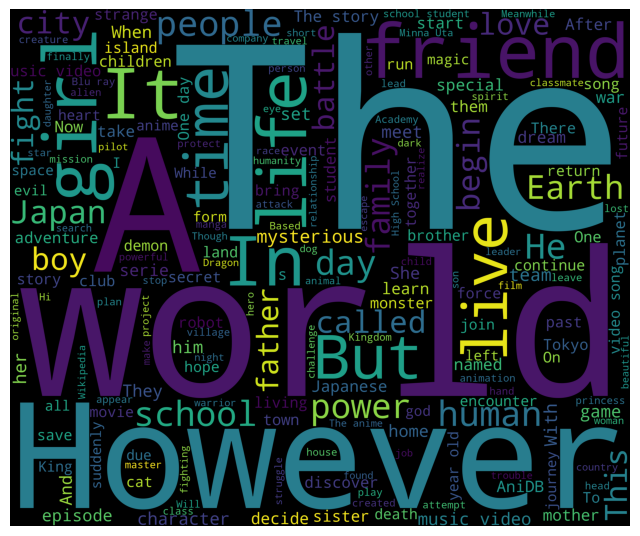

In [25]:
# Display the WordCloud using matplotlib
plt.figure(1, figsize=(8, 8))  # Create a figure with size 8x8 inches
plt.imshow(wordcloud)  # Display the wordcloud image
plt.axis('off')  # Turn off the axis
plt.show()  # Show the plot


In [26]:
### This code block is only run if you want to save the image in the working directory. 
#plt.figure(figsize=(12/2.54, 12/2.54))  # Set the scale of the plot (1 cm = 0.3937 pulgadas)

#plt.imshow(wordcloud)
#plt.axis('off')  # Ocultar los ejes

### Save the plot.
#plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')  # bbox_inches='tight' ajusta los márgenes
#plt.show()

## Bi-grams

In [27]:
# Create bigrams from the list of tokens
Bigrama = [' '.join(tokens[i:i+2]) for i in range(0, len(tokens)-1)]


In [28]:
# Create a DataFrame 'Bigrama' from the list of bigrams, with column name 'Bigrama'
Bigrama = pd.DataFrame(Bigrama, columns=['Bigrama'])

Bigrama


,Bigrama
0,"In 2071,"
1,"2071, humanity"
2,humanity colonized
3,colonized planets
4,planets moons
...,...
565025,dragging unavoidable
565026,unavoidable fate.
565027,fate. (Source:
565028,(Source: Official


In [29]:
# Calculate frequencies of each bigram in the 'Bigrama' DataFrame
FrecuenciaBigrama = (Bigrama
                     .groupby('Bigrama')  # Group bigrams by their value
                     .agg(frecuencia=("Bigrama", "count"))  # Count the frequency of each bigram
                     .reset_index()  # Reset index to make 'Bigrama' a regular column
                     .sort_values(by=["frecuencia"], ascending=False)  # Sort by frequency in descending order
                     .reset_index(drop=True)  # Reset index to start from 0
                    )


In [30]:
FrecuenciaBigrama[0:10]

,Bigrama,frecuencia
0,(Source: ANN),1982
1,ANN) |,1977
2,| The,1866
3,AniDB) |,786
4,(Source: AniDB),780
5,| In,705
6,. |,669
7,music video,600
8,The story,544
9,| usic,521


In [31]:
# Filter out bigrams with frequency greater than 20
FrecuenciaBigrama = FrecuenciaBigrama[FrecuenciaBigrama['frecuencia'] > 20]


In [32]:
FrecuenciaBigrama[0:9]

,Bigrama,frecuencia
0,(Source: ANN),1982
1,ANN) |,1977
2,| The,1866
3,AniDB) |,786
4,(Source: AniDB),780
5,| In,705
6,. |,669
7,music video,600
8,The story,544


In [33]:
# Split each element of the 'Bigrama' column into individual bigrams
bigramas_divididos = FrecuenciaBigrama['Bigrama'].apply(lambda x: x.split())

# Create separate lists for the first and second elements of each bigram
primer_elemento = []
segundo_elemento = []

# Iterate through each bigram in the split bigram lists
for bigrama in bigramas_divididos:
    # Check conditions to include the bigram
    if len(bigrama) == 2 and bigrama[0] != bigrama[1] and bigrama[0] != '|' and bigrama[1] != '|' and bigrama[0] != 'source' and bigrama[1] != 'source':
        # Append the first and second elements of the bigram to respective lists
        primer_elemento.append(bigrama[0])
        segundo_elemento.append(bigrama[1])
    else:
        # Print a message for bigrams not included based on conditions
        print('Bigrama no incluido: ' + str(bigrama))



Bigrama no incluido: ['ANN)', '|']
Bigrama no incluido: ['|', 'The']
Bigrama no incluido: ['AniDB)', '|']
Bigrama no incluido: ['|', 'In']
Bigrama no incluido: ['.', '|']
Bigrama no incluido: ['|', 'usic']
Bigrama no incluido: ['Wikipedia)', '|']
Bigrama no incluido: ['|', 'fter']
Bigrama no incluido: ['|', 'Short']
Bigrama no incluido: ['|', 'Based']
Bigrama no incluido: ['|', 'This']
Bigrama no incluido: ['series.', '|']
Bigrama no incluido: ['News)', '|']
Bigrama no incluido: ['|', 'Second']
Bigrama no incluido: ['|', 'music']
Bigrama no incluido: ['|', 'ducational']
Bigrama no incluido: ['|', 'short']
Bigrama no incluido: ['|', 'cap']
Bigrama no incluido: ['|', 'hen']
Bigrama no incluido: ['|', 'Official']
Bigrama no incluido: ['AnimeNfo)', '|']
Bigrama no incluido: ['Encyclopedia)', '|']
Bigrama no incluido: ['edited)', '|']
Bigrama no incluido: ['|', 'It']
Bigrama no incluido: ['|', 'Two']
Bigrama no incluido: ['Crunchyroll)', '|']
Bigrama no incluido: ['|', 'Special']
Bigrama no

In [34]:
# Create a DataFrame 'Bigrama' from the lists primer_elemento and segundo_elemento
Bigrama = pd.DataFrame({'V1': primer_elemento, 'V2': segundo_elemento})


In [35]:
Bigrama

,V1,V2
0,(Source:,ANN)
1,(Source:,AniDB)
2,music,video
3,The,story
4,usic,video
...,...,...
326,(Source:,FUNimation)
327,Cataloging,Japan)
328,Japan.,(Source:
329,(Source:,Collaborative


In [36]:
# Concatenate primer_elemento and segundo_elemento lists into a single list
Concatenado = primer_elemento + segundo_elemento


In [37]:
# Obtain unique values from the list Concatenado and convert them into a DataFrame
df_tokens = pd.DataFrame({'token': list(set(Concatenado))})

# Generate unique identifiers
df_tokens['Identificador'] = range(len(df_tokens))

# Set 'Identificador' as the index
df_tokens.set_index('Identificador', inplace=True)

# Reset the index to make 'Identificador' a regular column
df_tokens.reset_index(inplace=True)


df_tokens


,Identificador,token
0,0,Of
1,1,life.
2,2,specials.
3,3,"However,"
4,4,short
...,...,...
304,304,Hello
305,305,beautiful
306,306,race
307,307,rock


In [38]:
# Merge Bigrama with df_tokens based on 'V1' to get identifiers for the first element
# Then merge the result with df_tokens again based on 'V2' to get identifiers for the second element
Identificados = Bigrama.merge(df_tokens, left_on='V1', right_on="token", how="left") \
                      .merge(df_tokens, left_on='V2', right_on="token", how="left")


Identificados.head(10)


,V1,V2,Identificador_x,token_x,Identificador_y,token_y
0,(Source:,ANN),96,(Source:,91,ANN)
1,(Source:,AniDB),96,(Source:,174,AniDB)
2,music,video,161,music,124,video
3,The,story,75,The,195,story
4,usic,video,126,usic,124,video
5,video,song,124,video,130,song
6,One,"day,",260,One,49,"day,"
7,(Source:,Wikipedia),96,(Source:,238,Wikipedia)
8,Minna,Uta,143,Minna,66,Uta
9,NHK's,Minna,225,NHK's,143,Minna


In [39]:
# Create a DataFrame 'Aristas' containing columns 'Identificador_x' and 'Identificador_y' from 'Identificados'
Aristas = Identificados[['Identificador_x', 'Identificador_y']]

Aristas

,Identificador_x,Identificador_y
0,96,91
1,96,174
2,161,124
3,75,195
4,126,124
...,...,...
326,96,286
327,95,10
328,114,96
329,96,7


In [40]:
# Create a graph g from the DataFrame Aristas, assuming it's an undirected graph (directed=False)
g = ig.Graph.DataFrame(Aristas, directed=False)

# Assign names to the vertices based on the tokens in df_tokens
g.vs['name'] = df_tokens['token']

# Assign a color to all vertices using the adjustcolor function (assuming it returns RGBA values)
g.vs['color'] = adjustcolor('red', 0.4)

In [41]:
# Find the giant connected component (largest connected component) of the graph g
cg = g.components().giant()


In [42]:

np.random.seed(123)

# Generate a Fruchterman-Reingold layout for the giant connected component (cg)
lg = cg.layout_fruchterman_reingold()

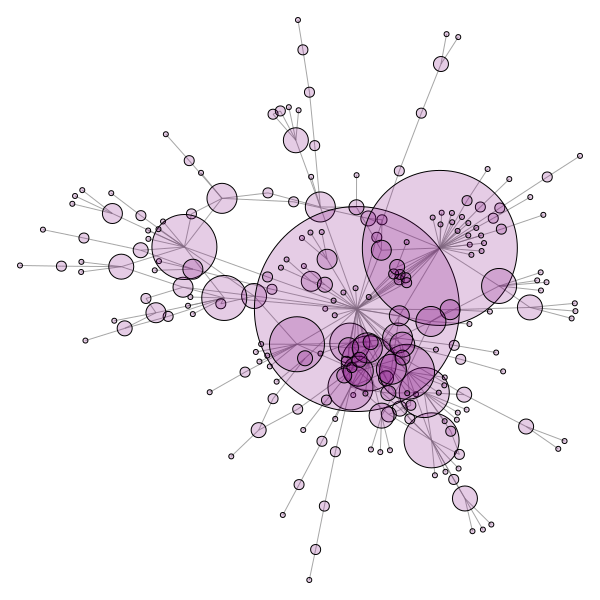

In [43]:
# Define vertex labels as dictionary where each vertex index is mapped to its index converted to string
vertex_labels = {v.index: str(v.index) for v in cg.vs}

# Plot the graph with labels
ig.plot(cg,
        layout=lg,  # Use the previously defined layout
        vertex_label_dist=0.5,  # Adjust distance of vertex labels from vertices
        vertex_label_color='black',  # Set color of vertex labels
        vertex_label_size=10,  # Set size of vertex labels
        vertex_color=adjustcolor("purple", 0.2),  # Set color of vertices
        vertex_size=[cg.degree()[v.index] * 5 if cg.degree()[v.index] * 5 > 3 else 3 for v in cg.vs],  # Set size of vertices based on degree
        edge_color=adjustcolor('gray', 0.7),  # Set color of edges
        background=None  # Set background color to None (transparent)
        )


In [44]:
# Calculate graph metrics
distancia_media = g.average_path_length()  # Average path length
grado_medio = sum(g.degree()) / len(g.vs)  # Average degree
grado_desviacion = g.assortativity_degree()  # Degree assortativity
numero_clan = len(g.largest_cliques()[0])  # Size of the largest clique
densidad = g.density()  # Graph density
transitividad = g.transitivity_undirected()  # Graph transitivity
asortatividad = g.assortativity_degree()  # Assortativity

# Print the results
print("Average path length:", distancia_media)
print("Average degree:", grado_medio)
print("Degree assortativity:", grado_desviacion)
print("Size of the largest clique:", numero_clan)
print("Graph density:", densidad)
print("Graph transitivity:", transitividad)
print("Assortativity:", asortatividad)


Average path length: 4.380649717514125
Average degree: 2.1423948220064726
Degree assortativity: -0.10266991506513774
Size of the largest clique: 4
Graph density: 0.006955827344176859
Graph transitivity: 0.0556083650190114
Assortativity: -0.10266991506513774


In [45]:
np.random.seed(12)

# Community detection algorithm by edge betweenness
eb = cg.community_edge_betweenness()

# Community detection algorithm Infomap
im = cg.community_infomap()

# Community detection algorithm Label Propagation
lp = cg.community_label_propagation()

# Community detection algorithm Leading eigenvector
le = cg.community_leading_eigenvector()

# Community detection algorithm Walktrap
wt = cg.community_walktrap()

# Community detection algorithm Spinglass
sg = cg.community_spinglass()

# Community detection algorithm Multilevel
ml = cg.community_multilevel()


In [46]:
# Convert the results into clustering objects
eb_clustering = eb.as_clustering()
wt_clustering = wt.as_clustering()

# Print the modularity of each community detection method
print("Modularity of community_edge_betweenness:", round(eb_clustering.modularity, 3))
print("Modularity of community_infomap:", round(im.modularity, 3))
print("Modularity of community_label_propagation:", round(lp.modularity, 3))
print("Modularity of community_leading_eigenvector:", round(le.modularity, 3))
print("Modularity of community_walktrap:", round(wt_clustering.modularity, 3))
print("Modularity of community_spinglass:", round(sg.modularity, 3))
print("Modularity of community_multilevel:", round(ml.modularity, 3))

Modularity of community_edge_betweenness: 0.681
Modularity of community_infomap: 0.643
Modularity of community_label_propagation: 0.626
Modularity of community_leading_eigenvector: 0.598
Modularity of community_walktrap: 0.638
Modularity of community_spinglass: 0.689
Modularity of community_multilevel: 0.689


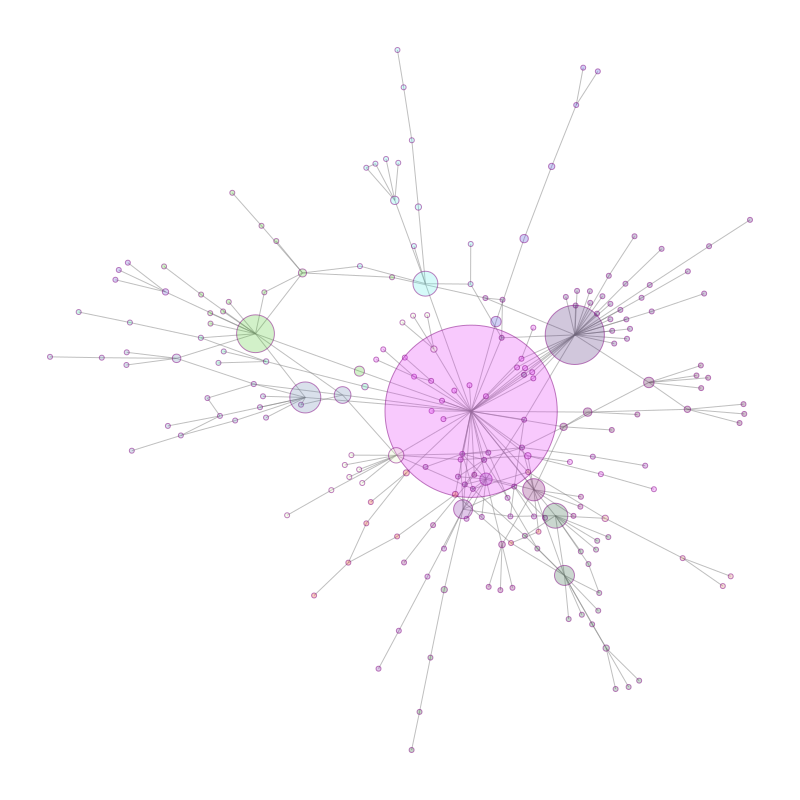

In [47]:
import igraph as ig

# Plot the graph with specified parameters
ig.plot(cg,
        layout=lg,  # Use the previously defined layout
        edge_color=adjustcolor('gray', 0.5),  # Set edge color
        vertex_frame_color=adjustcolor('purple', 0.5),  # Set vertex frame color
        vertex_color=get_colors_for_list(sg.membership, alpha=0.25),  # Color vertices based on community membership
        vertex_size=[cg*0.01 if cg*0.01 > 5 else 5 for cg in cg.betweenness()],  # Adjust vertex size based on betweenness centrality
        bbox=(800, 800),  # Set bounding box size for the plot
        margin=50  # Set margin size
        )
